<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC_Kmeans_CSE425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import pandas as pd

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


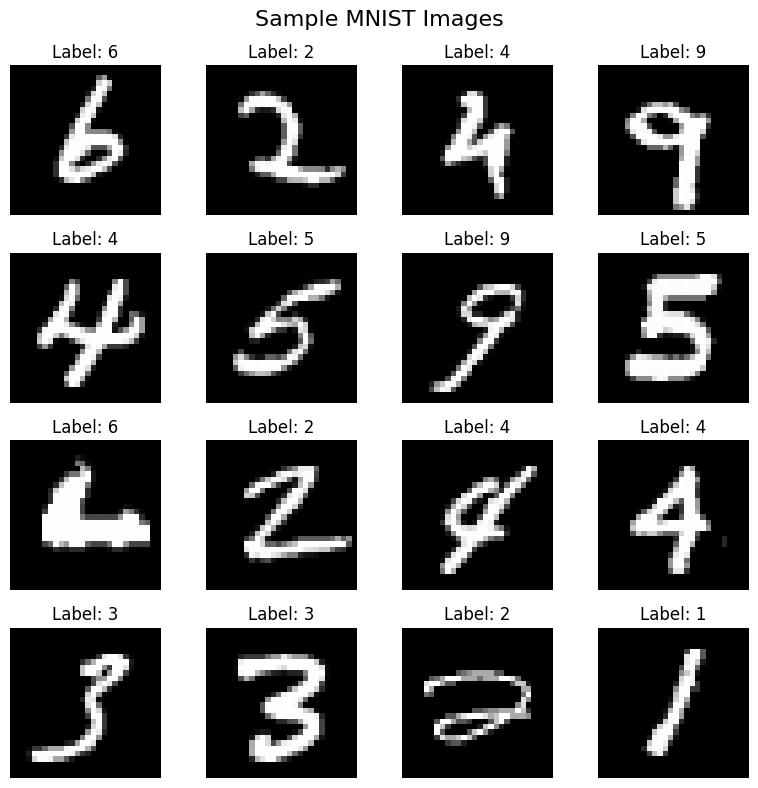

In [ ]:


# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 16 images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample MNIST Images", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-14-e5b6255af81d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Digit", data=label_df, palette="viridis")


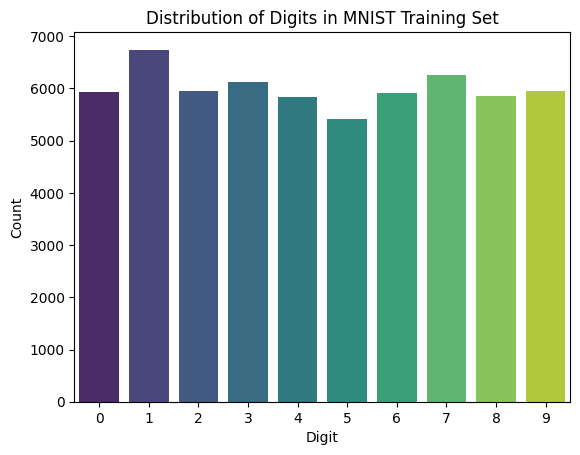

In [ ]:


# Collect all labels from the full dataset
all_labels = [label for _, label in train_dataset]

# Create a bar plot of label distribution
label_df = pd.DataFrame(all_labels, columns=["Digit"])
sns.countplot(x="Digit", data=label_df, palette="viridis")
plt.title("Distribution of Digits in MNIST Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [ ]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(30):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1: 100%|██████████| 235/235 [00:13<00:00, 17.08it/s]


Epoch 1, Loss: 0.4385


AE Epoch 2: 100%|██████████| 235/235 [00:13<00:00, 17.01it/s]


Epoch 2, Loss: 0.1375


AE Epoch 3: 100%|██████████| 235/235 [00:13<00:00, 16.88it/s]


Epoch 3, Loss: 0.0914


AE Epoch 4: 100%|██████████| 235/235 [00:14<00:00, 16.54it/s]


Epoch 4, Loss: 0.0817


AE Epoch 5: 100%|██████████| 235/235 [00:13<00:00, 17.09it/s]


Epoch 5, Loss: 0.0762


AE Epoch 6: 100%|██████████| 235/235 [00:14<00:00, 16.77it/s]


Epoch 6, Loss: 0.0725


AE Epoch 7: 100%|██████████| 235/235 [00:14<00:00, 16.01it/s]


Epoch 7, Loss: 0.0697


AE Epoch 8: 100%|██████████| 235/235 [00:13<00:00, 16.84it/s]


Epoch 8, Loss: 0.0675


AE Epoch 9: 100%|██████████| 235/235 [00:13<00:00, 17.13it/s]


Epoch 9, Loss: 0.0657


AE Epoch 10: 100%|██████████| 235/235 [00:13<00:00, 17.18it/s]


Epoch 10, Loss: 0.0641


AE Epoch 11: 100%|██████████| 235/235 [00:14<00:00, 16.51it/s]


Epoch 11, Loss: 0.0628


AE Epoch 12: 100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


Epoch 12, Loss: 0.0616


AE Epoch 13: 100%|██████████| 235/235 [00:13<00:00, 17.25it/s]


Epoch 13, Loss: 0.0606


AE Epoch 14: 100%|██████████| 235/235 [00:13<00:00, 17.08it/s]


Epoch 14, Loss: 0.0596


AE Epoch 15: 100%|██████████| 235/235 [00:13<00:00, 17.08it/s]


Epoch 15, Loss: 0.0589


AE Epoch 16: 100%|██████████| 235/235 [00:13<00:00, 17.13it/s]


Epoch 16, Loss: 0.0581


AE Epoch 17: 100%|██████████| 235/235 [00:13<00:00, 17.10it/s]


Epoch 17, Loss: 0.0574


AE Epoch 18: 100%|██████████| 235/235 [00:13<00:00, 17.00it/s]


Epoch 18, Loss: 0.0568


AE Epoch 19: 100%|██████████| 235/235 [00:14<00:00, 16.78it/s]


Epoch 19, Loss: 0.0563


AE Epoch 20: 100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


Epoch 20, Loss: 0.0558


AE Epoch 21: 100%|██████████| 235/235 [00:13<00:00, 16.91it/s]


Epoch 21, Loss: 0.0553


AE Epoch 22: 100%|██████████| 235/235 [00:13<00:00, 17.15it/s]


Epoch 22, Loss: 0.0548


AE Epoch 23: 100%|██████████| 235/235 [00:14<00:00, 16.11it/s]


Epoch 23, Loss: 0.0545


AE Epoch 24: 100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


Epoch 24, Loss: 0.0541


AE Epoch 25: 100%|██████████| 235/235 [00:13<00:00, 16.80it/s]


Epoch 25, Loss: 0.0537


AE Epoch 26: 100%|██████████| 235/235 [00:14<00:00, 16.72it/s]


Epoch 26, Loss: 0.0534


AE Epoch 27: 100%|██████████| 235/235 [00:13<00:00, 17.23it/s]


Epoch 27, Loss: 0.0531


AE Epoch 28: 100%|██████████| 235/235 [00:13<00:00, 17.03it/s]


Epoch 28, Loss: 0.0528


AE Epoch 29: 100%|██████████| 235/235 [00:13<00:00, 17.21it/s]


Epoch 29, Loss: 0.0526


AE Epoch 30: 100%|██████████| 235/235 [00:13<00:00, 17.16it/s]

Epoch 30, Loss: 0.0524


In [ ]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(103):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1: 100%|██████████| 235/235 [00:13<00:00, 16.89it/s]


[DEC] Epoch 1, Loss: 0.2215


DEC Epoch 2: 100%|██████████| 235/235 [00:13<00:00, 17.05it/s]


[DEC] Epoch 2, Loss: 0.1952


DEC Epoch 3: 100%|██████████| 235/235 [00:13<00:00, 17.22it/s]


[DEC] Epoch 3, Loss: 0.1833


DEC Epoch 4: 100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


[DEC] Epoch 4, Loss: 0.1753


DEC Epoch 5: 100%|██████████| 235/235 [00:13<00:00, 17.07it/s]


[DEC] Epoch 5, Loss: 0.1687


DEC Epoch 6: 100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


[DEC] Epoch 6, Loss: 0.1633


DEC Epoch 7: 100%|██████████| 235/235 [00:13<00:00, 16.96it/s]


[DEC] Epoch 7, Loss: 0.1590


DEC Epoch 8: 100%|██████████| 235/235 [00:13<00:00, 17.41it/s]


[DEC] Epoch 8, Loss: 0.1551


DEC Epoch 9: 100%|██████████| 235/235 [00:14<00:00, 16.30it/s]


[DEC] Epoch 9, Loss: 0.1515


DEC Epoch 10: 100%|██████████| 235/235 [00:14<00:00, 16.71it/s]


[DEC] Epoch 10, Loss: 0.1487


DEC Epoch 11: 100%|██████████| 235/235 [00:13<00:00, 17.46it/s]


[DEC] Epoch 11, Loss: 0.1458


DEC Epoch 12: 100%|██████████| 235/235 [00:13<00:00, 17.33it/s]


[DEC] Epoch 12, Loss: 0.1428


DEC Epoch 13: 100%|██████████| 235/235 [00:13<00:00, 17.40it/s]


[DEC] Epoch 13, Loss: 0.1410


DEC Epoch 14: 100%|██████████| 235/235 [00:13<00:00, 17.30it/s]


[DEC] Epoch 14, Loss: 0.1386


DEC Epoch 15: 100%|██████████| 235/235 [00:13<00:00, 17.39it/s]


[DEC] Epoch 15, Loss: 0.1367


DEC Epoch 16: 100%|██████████| 235/235 [00:13<00:00, 17.41it/s]


[DEC] Epoch 16, Loss: 0.1346


DEC Epoch 17: 100%|██████████| 235/235 [00:13<00:00, 17.44it/s]


[DEC] Epoch 17, Loss: 0.1326


DEC Epoch 18: 100%|██████████| 235/235 [00:13<00:00, 16.94it/s]


[DEC] Epoch 18, Loss: 0.1309


DEC Epoch 19: 100%|██████████| 235/235 [00:13<00:00, 16.94it/s]


[DEC] Epoch 19, Loss: 0.1296


DEC Epoch 20: 100%|██████████| 235/235 [00:13<00:00, 17.49it/s]


[DEC] Epoch 20, Loss: 0.1278


DEC Epoch 21: 100%|██████████| 235/235 [00:13<00:00, 17.39it/s]


[DEC] Epoch 21, Loss: 0.1268


DEC Epoch 22: 100%|██████████| 235/235 [00:13<00:00, 17.45it/s]


[DEC] Epoch 22, Loss: 0.1251


DEC Epoch 23: 100%|██████████| 235/235 [00:13<00:00, 17.52it/s]


[DEC] Epoch 23, Loss: 0.1239


DEC Epoch 24: 100%|██████████| 235/235 [00:13<00:00, 17.67it/s]


[DEC] Epoch 24, Loss: 0.1225


DEC Epoch 25: 100%|██████████| 235/235 [00:14<00:00, 16.47it/s]


[DEC] Epoch 25, Loss: 0.1212


DEC Epoch 26: 100%|██████████| 235/235 [00:13<00:00, 17.25it/s]


[DEC] Epoch 26, Loss: 0.1202


DEC Epoch 27: 100%|██████████| 235/235 [00:13<00:00, 17.00it/s]


[DEC] Epoch 27, Loss: 0.1189


DEC Epoch 28: 100%|██████████| 235/235 [00:13<00:00, 16.91it/s]


[DEC] Epoch 28, Loss: 0.1178


DEC Epoch 29: 100%|██████████| 235/235 [00:13<00:00, 17.49it/s]


[DEC] Epoch 29, Loss: 0.1167


DEC Epoch 30: 100%|██████████| 235/235 [00:13<00:00, 17.53it/s]


[DEC] Epoch 30, Loss: 0.1154


DEC Epoch 31: 100%|██████████| 235/235 [00:13<00:00, 17.41it/s]


[DEC] Epoch 31, Loss: 0.1146


DEC Epoch 32: 100%|██████████| 235/235 [00:13<00:00, 17.15it/s]


[DEC] Epoch 32, Loss: 0.1138


DEC Epoch 33: 100%|██████████| 235/235 [00:13<00:00, 17.54it/s]


[DEC] Epoch 33, Loss: 0.1126


DEC Epoch 34: 100%|██████████| 235/235 [00:13<00:00, 17.40it/s]


[DEC] Epoch 34, Loss: 0.1115


DEC Epoch 35: 100%|██████████| 235/235 [00:13<00:00, 17.17it/s]


[DEC] Epoch 35, Loss: 0.1106


DEC Epoch 36: 100%|██████████| 235/235 [00:14<00:00, 16.61it/s]


[DEC] Epoch 36, Loss: 0.1098


DEC Epoch 37: 100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


[DEC] Epoch 37, Loss: 0.1091


DEC Epoch 38: 100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


[DEC] Epoch 38, Loss: 0.1080


DEC Epoch 39: 100%|██████████| 235/235 [00:13<00:00, 17.30it/s]


[DEC] Epoch 39, Loss: 0.1071


DEC Epoch 40: 100%|██████████| 235/235 [00:13<00:00, 17.24it/s]


[DEC] Epoch 40, Loss: 0.1066


DEC Epoch 41: 100%|██████████| 235/235 [00:14<00:00, 16.40it/s]


[DEC] Epoch 41, Loss: 0.1057


DEC Epoch 42: 100%|██████████| 235/235 [00:13<00:00, 17.32it/s]


[DEC] Epoch 42, Loss: 0.1049


DEC Epoch 43: 100%|██████████| 235/235 [00:13<00:00, 17.16it/s]


[DEC] Epoch 43, Loss: 0.1042


DEC Epoch 44: 100%|██████████| 235/235 [00:14<00:00, 16.54it/s]


[DEC] Epoch 44, Loss: 0.1038


DEC Epoch 45: 100%|██████████| 235/235 [00:13<00:00, 16.99it/s]


[DEC] Epoch 45, Loss: 0.1028


DEC Epoch 46: 100%|██████████| 235/235 [00:13<00:00, 17.33it/s]


[DEC] Epoch 46, Loss: 0.1021


DEC Epoch 47: 100%|██████████| 235/235 [00:13<00:00, 17.17it/s]


[DEC] Epoch 47, Loss: 0.1015


DEC Epoch 48: 100%|██████████| 235/235 [00:13<00:00, 17.33it/s]


[DEC] Epoch 48, Loss: 0.1008


DEC Epoch 49: 100%|██████████| 235/235 [00:13<00:00, 17.24it/s]


[DEC] Epoch 49, Loss: 0.1001


DEC Epoch 50: 100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


[DEC] Epoch 50, Loss: 0.0996


DEC Epoch 51: 100%|██████████| 235/235 [00:13<00:00, 17.44it/s]


[DEC] Epoch 51, Loss: 0.0991


DEC Epoch 52: 100%|██████████| 235/235 [00:13<00:00, 16.80it/s]


[DEC] Epoch 52, Loss: 0.0984


DEC Epoch 53: 100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


[DEC] Epoch 53, Loss: 0.0976


DEC Epoch 54: 100%|██████████| 235/235 [00:13<00:00, 17.05it/s]


[DEC] Epoch 54, Loss: 0.0973


DEC Epoch 55: 100%|██████████| 235/235 [00:13<00:00, 17.32it/s]


[DEC] Epoch 55, Loss: 0.0966


DEC Epoch 56: 100%|██████████| 235/235 [00:13<00:00, 17.36it/s]


[DEC] Epoch 56, Loss: 0.0958


DEC Epoch 57: 100%|██████████| 235/235 [00:14<00:00, 16.32it/s]


[DEC] Epoch 57, Loss: 0.0956


DEC Epoch 58: 100%|██████████| 235/235 [00:13<00:00, 17.30it/s]


[DEC] Epoch 58, Loss: 0.0953


DEC Epoch 59: 100%|██████████| 235/235 [00:13<00:00, 17.51it/s]


[DEC] Epoch 59, Loss: 0.0947


DEC Epoch 60: 100%|██████████| 235/235 [00:13<00:00, 16.93it/s]


[DEC] Epoch 60, Loss: 0.0942


DEC Epoch 61: 100%|██████████| 235/235 [00:14<00:00, 16.74it/s]


[DEC] Epoch 61, Loss: 0.0933


DEC Epoch 62: 100%|██████████| 235/235 [00:13<00:00, 17.03it/s]


[DEC] Epoch 62, Loss: 0.0932


DEC Epoch 63: 100%|██████████| 235/235 [00:13<00:00, 17.50it/s]


[DEC] Epoch 63, Loss: 0.0923


DEC Epoch 64: 100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


[DEC] Epoch 64, Loss: 0.0920


DEC Epoch 65: 100%|██████████| 235/235 [00:13<00:00, 17.48it/s]


[DEC] Epoch 65, Loss: 0.0917


DEC Epoch 66: 100%|██████████| 235/235 [00:13<00:00, 17.35it/s]


[DEC] Epoch 66, Loss: 0.0911


DEC Epoch 67: 100%|██████████| 235/235 [00:13<00:00, 17.45it/s]


[DEC] Epoch 67, Loss: 0.0907


DEC Epoch 68: 100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


[DEC] Epoch 68, Loss: 0.0905


DEC Epoch 69: 100%|██████████| 235/235 [00:13<00:00, 17.01it/s]


[DEC] Epoch 69, Loss: 0.0897


DEC Epoch 70: 100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


[DEC] Epoch 70, Loss: 0.0895


DEC Epoch 71: 100%|██████████| 235/235 [00:13<00:00, 17.43it/s]


[DEC] Epoch 71, Loss: 0.0890


DEC Epoch 72: 100%|██████████| 235/235 [00:13<00:00, 17.52it/s]


[DEC] Epoch 72, Loss: 0.0885


DEC Epoch 73: 100%|██████████| 235/235 [00:13<00:00, 16.99it/s]


[DEC] Epoch 73, Loss: 0.0886


DEC Epoch 74: 100%|██████████| 235/235 [00:13<00:00, 17.75it/s]


[DEC] Epoch 74, Loss: 0.0880


DEC Epoch 75: 100%|██████████| 235/235 [00:13<00:00, 17.68it/s]


[DEC] Epoch 75, Loss: 0.0874


DEC Epoch 76: 100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


[DEC] Epoch 76, Loss: 0.0870


DEC Epoch 77: 100%|██████████| 235/235 [00:13<00:00, 17.57it/s]


[DEC] Epoch 77, Loss: 0.0867


DEC Epoch 78: 100%|██████████| 235/235 [00:13<00:00, 17.03it/s]


[DEC] Epoch 78, Loss: 0.0866


DEC Epoch 79: 100%|██████████| 235/235 [00:13<00:00, 17.11it/s]


[DEC] Epoch 79, Loss: 0.0860


DEC Epoch 80: 100%|██████████| 235/235 [00:13<00:00, 17.57it/s]


[DEC] Epoch 80, Loss: 0.0862


DEC Epoch 81: 100%|██████████| 235/235 [00:13<00:00, 17.42it/s]


[DEC] Epoch 81, Loss: 0.0851


DEC Epoch 82: 100%|██████████| 235/235 [00:13<00:00, 17.70it/s]


[DEC] Epoch 82, Loss: 0.0853


DEC Epoch 83: 100%|██████████| 235/235 [00:13<00:00, 17.65it/s]


[DEC] Epoch 83, Loss: 0.0844


DEC Epoch 84: 100%|██████████| 235/235 [00:13<00:00, 17.40it/s]


[DEC] Epoch 84, Loss: 0.0843


DEC Epoch 85: 100%|██████████| 235/235 [00:13<00:00, 17.68it/s]


[DEC] Epoch 85, Loss: 0.0840


DEC Epoch 86: 100%|██████████| 235/235 [00:13<00:00, 17.47it/s]


[DEC] Epoch 86, Loss: 0.0838


DEC Epoch 87: 100%|██████████| 235/235 [00:13<00:00, 17.60it/s]


[DEC] Epoch 87, Loss: 0.0836


DEC Epoch 88: 100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


[DEC] Epoch 88, Loss: 0.0829


DEC Epoch 89: 100%|██████████| 235/235 [00:14<00:00, 16.31it/s]


[DEC] Epoch 89, Loss: 0.0828


DEC Epoch 90: 100%|██████████| 235/235 [00:13<00:00, 17.67it/s]


[DEC] Epoch 90, Loss: 0.0827


DEC Epoch 91: 100%|██████████| 235/235 [00:13<00:00, 17.57it/s]


[DEC] Epoch 91, Loss: 0.0823


DEC Epoch 92: 100%|██████████| 235/235 [00:13<00:00, 17.56it/s]


[DEC] Epoch 92, Loss: 0.0819


DEC Epoch 93: 100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


[DEC] Epoch 93, Loss: 0.0816


DEC Epoch 94: 100%|██████████| 235/235 [00:13<00:00, 17.21it/s]


[DEC] Epoch 94, Loss: 0.0810


DEC Epoch 95: 100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


[DEC] Epoch 95, Loss: 0.0813


DEC Epoch 96: 100%|██████████| 235/235 [00:13<00:00, 16.98it/s]


[DEC] Epoch 96, Loss: 0.0807


DEC Epoch 97: 100%|██████████| 235/235 [00:13<00:00, 16.82it/s]


[DEC] Epoch 97, Loss: 0.0803


DEC Epoch 98: 100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


[DEC] Epoch 98, Loss: 0.0800


DEC Epoch 99: 100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


[DEC] Epoch 99, Loss: 0.0799


DEC Epoch 100: 100%|██████████| 235/235 [00:13<00:00, 17.30it/s]


[DEC] Epoch 100, Loss: 0.0796


DEC Epoch 101: 100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


[DEC] Epoch 101, Loss: 0.0792


DEC Epoch 102: 100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


[DEC] Epoch 102, Loss: 0.0792


DEC Epoch 103: 100%|██████████| 235/235 [00:13<00:00, 17.19it/s]

[DEC] Epoch 103, Loss: 0.0788


In [ ]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7801
Davies-Bouldin Index:     0.2817
Calinski-Harabasz Index:  251805.0781


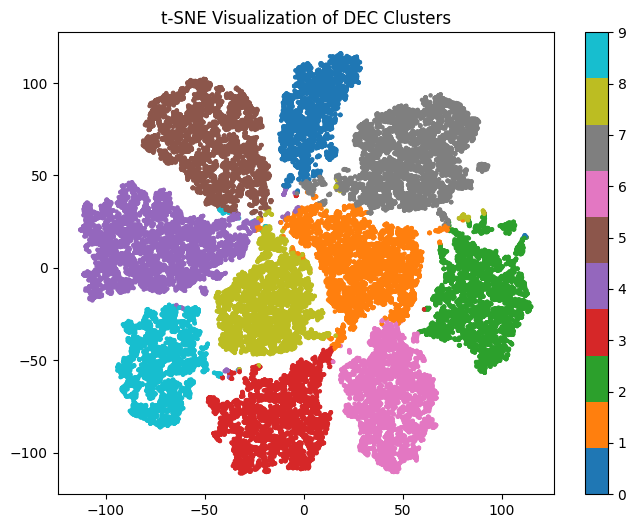

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [ ]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
